<a href="https://colab.research.google.com/github/Omadzze/food_classification/blob/main/Food_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.v2 import ToTensor, Lambda

from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Defining transform

In [4]:
EPOCHS = 10

In [5]:
ROTATION_RANGE_MIN = 0
ROTATION_RANGE_MAX = 150
FLIPPING = 0.5

BRIGHTNESS = 0.2
CONTRAST = 0.2
SATURATION = 0.2
HUE = 0.1

In [6]:
# https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde
# about transforms and etc

MEAN = [0.5450, 0.4435, 0.3436]
STD = [0.2302, 0.2409, 0.2387]
# Transform to convert images and resize them, so we could use pre-trained models
# Note apply only to the training set!
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),

    # Data augmentation
    transforms.ColorJitter(brightness = BRIGHTNESS, contrast = CONTRAST, saturation = SATURATION, hue = HUE), # different brigtness, contrast
    transforms.RandomRotation(degrees=(ROTATION_RANGE_MIN, ROTATION_RANGE_MAX)), # rotation of the image

    transforms.RandomHorizontalFlip(p=FLIPPING),
    transforms.RandomVerticalFlip(p=FLIPPING),


])

In [ ]:
def data_loading():
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

data_loading()

 98%|█████████▊| 4.88G/5.00G [08:27<00:09, 12.4MB/s]

In [ ]:
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

In [ ]:
len(train_data), len(test_data)

(75750, 25250)

We have 75750 training images and 25250 testing images

In [ ]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 23)

In [ ]:
print(f"Image shape: {image.shape}")
print(f"Class label: {class_names[label]}")

Image shape: torch.Size([3, 224, 224])
Class label: churros


In [ ]:
len(train_data.classes)

101

# Visualize image

In [ ]:
print(image.squeeze().shape)

torch.Size([3, 224, 224])


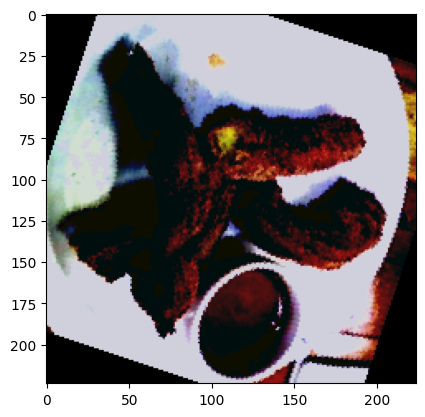

In [ ]:
# transform an image from (C, H, W) to (H, W, C) to visualize it
image_permute = image.permute(1, 2, 0)
plt.imshow(image_permute)

# Plot random images

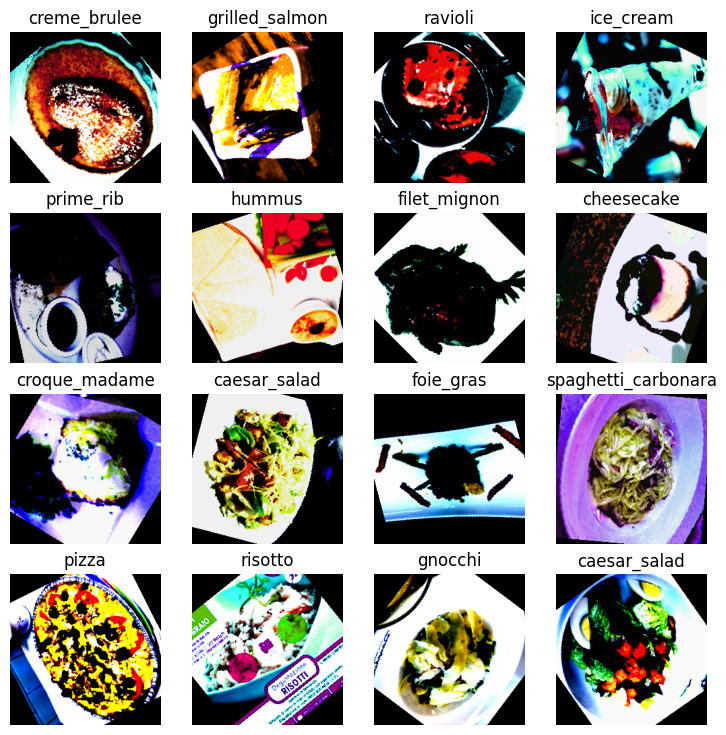

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis("off")

### Calculates global normalization stastics.
This will help to normalize pixel values, increase convergence of a model

In [ ]:
"""
from tqdm import tqdm
train_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)

mean = torch.zeros(3, device=device)
std = torch.zeros(3, device=device)
nb_samples = 0.

for data, _ in tqdm(train_loader, total=len(train_loader)):
    # Put data to GPU
    data = data.to(device)
    batch_samples = data.size(0)
    # Flatten height and width
    data = data.view(batch_samples, data.size(1), -1)
    # Calculate mean and std
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Calculate global mean and std
mean /= nb_samples
std /= nb_samples

print("Global Mean:", mean)
print("Global Std:", std)
"""

'\nfrom tqdm import tqdm\ntrain_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)\n\nmean = torch.zeros(3, device=device)\nstd = torch.zeros(3, device=device)\nnb_samples = 0.\n\nfor data, _ in tqdm(train_loader, total=len(train_loader)):\n    # Put data to GPU\n    data = data.to(device)\n    batch_samples = data.size(0)\n    # Flatten height and width\n    data = data.view(batch_samples, data.size(1), -1)\n    # Calculate mean and std\n    mean += data.mean(2).sum(0)\n    std += data.std(2).sum(0)\n    nb_samples += batch_samples\n\n# Calculate global mean and std\nmean /= nb_samples\nstd /= nb_samples\n\nprint("Global Mean:", mean)\nprint("Global Std:", std)\n'

## Building Custom CNN

In [ ]:
DROPOUT = 0.25

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes = 101):
        super().__init__()

        # Original [3, 224, 224]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # dimensionality reduction [64, 112, 112]
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Second layer [128, 56, 56]
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third layer [256, 28, 28]
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fourth layer [512, 14, 14]
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # adaptive pooling: transforms [batch, 512, H, W] to [batch, 512, 1, 1]
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout
        self.dropout = nn.Dropout(p=DROPOUT)

        # Fully connected layer
        # [batch, 512, 1, 1]
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Note that deeper we go the more complex features model can recognize
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.adaptive_pool(x) #[batch, 512, 1, 1]
        # Flatten [batch, 512]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x= self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
custom_model = CustomCNN()
# put model to GPU
custom_model = custom_model.to(device)

# DataLoader

In [ ]:
# Splitting data to the training and validation
val_size = int(len(train_data) * 0.2)
train_size = len(train_data) - val_size

train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)
validation_loader = DataLoader(val_data, batch_size=32, num_workers=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(validation_loader)}")
print(f"Test size: {len(test_data)}")

Train size: 60600
Validation size: 474
Test size: 25250


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


# Setup optimizers, loss

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = custom_model.parameters(), lr = 0.01)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# Training loop

In [ ]:
"""
def train_loop(train_loader, model, loss_fn, optimizer):
    progress_bar = tqdm(train_loader, total=len(train_loader), desc="Training", unit="batch")

    model.train()
    for batch, (X, y) in enumerate(progress_bar):
        optimizer.zero_grad()
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()


def test_loop(val_loader, model, loss_fn, setup):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, total=len(val_loader), desc=setup, unit="batch")

    with torch.no_grad():
        for X, y in progress_bar:
            pred = model(X)
            total_loss += loss_fn(pred, y).item() * X.size(0)
            predicted = torch.argmax(pred, dim = 1)
            correct += (predicted == y).sum().item()
            total += X.size(0)
    average_loss = total_loss / total
    accuracy = correct / total * 100
    return average_loss, accuracy



for epoch in range(EPOCHS):
    train_loop(train_loader, custom_model, loss_fn, optimizer)
    valid_loss, valid_accuracy = test_loop(val_loader, custom_model, loss_fn, setup="Validation")
    print(f"Epoch {epoch+1}: Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

test_loss, test_accuracy = test_loop(test_loader, custom_model, loss_fn, setup="Test")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
"""

'\ndef train_loop(train_loader, model, loss_fn, optimizer):\n    progress_bar = tqdm(train_loader, total=len(train_loader), desc="Training", unit="batch")\n\n    model.train()\n    for batch, (X, y) in enumerate(progress_bar):\n        optimizer.zero_grad()\n        # compute prediction and loss\n        pred = model(X)\n        loss = loss_fn(pred, y)\n\n        # backpropagation\n        loss.backward()\n        optimizer.step()\n\n\ndef test_loop(val_loader, model, loss_fn, setup):\n    model.eval()\n    total_loss = 0.0\n    correct = 0\n    total = 0\n\n    progress_bar = tqdm(val_loader, total=len(val_loader), desc=setup, unit="batch")\n\n    with torch.no_grad():\n        for X, y in progress_bar:\n            pred = model(X)\n            total_loss += loss_fn(pred, y).item() * X.size(0)\n            predicted = torch.argmax(pred, dim = 1)\n            correct += (predicted == y).sum().item()\n            total += X.size(0)\n    average_loss = total_loss / total\n    accuracy = 

In [ ]:
import torch
from tqdm import tqdm
import wandb

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omadbek95 (omadbek95-technical-university-of-berlin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:

# Initialize wandb with your project name and configuration settings
wandb.init(project="food-project", config={
    "epochs": EPOCHS,
    "learning_rate": 0.001,  # update with your learning rate
    # add any other hyperparameters you want to track
})

def train_loop(train_loader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    progress_bar = tqdm(train_loader, total=len(train_loader), desc="Training", unit="batch")
    for batch, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()

        # accumulate training loss and accuracy
        total_loss += loss.item() * X.size(0)
        predicted = torch.argmax(pred, dim=1)
        total_correct += (predicted == y).sum().item()
        total_examples += X.size(0)

    average_loss = total_loss / total_examples
    accuracy = total_correct / total_examples * 100
    return average_loss, accuracy

def test_loop(val_loader, model, loss_fn, setup):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(validation_loader, total=len(validation_loader), desc=setup, unit="batch")
    with torch.no_grad():
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item() * X.size(0)
            predicted = torch.argmax(pred, dim=1)
            correct += (predicted == y).sum().item()
            total += X.size(0)
    average_loss = total_loss / total
    accuracy = correct / total * 100
    return average_loss, accuracy

# Training and Validation Loop
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_loop(train_loader, custom_model, loss_fn, optimizer)
    valid_loss, valid_accuracy = test_loop(validation_loader, custom_model, loss_fn, setup="Validation")

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy
    })

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

# Testing the Model
test_loss, test_accuracy = test_loop(test_loader, custom_model, loss_fn, setup="Test")
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
})
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the model after training and testing
torch.save(custom_model.state_dict(), "custom_model.pth")
print("Model saved as custom_model.pth")

NameError: name 'wandb' is not defined